In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [20]:
df_repeats_constrain, df_constrain = file_io.dfs_from_vcf(filename="../../data/simulated_reads/variants/ConSTRain_simulated_trisomy_21.vcf", samples=["simulated_trisomy_21"])
df_constrain = (df_constrain
                    .rename(columns = {"frequencies": "frequencies_constrain", "genotype": "genotype_constrain"})
                    .dropna()
                    .reset_index(drop=True)
                    .assign(depth = lambda x: [sum(i.values()) for i in x["frequencies_constrain"]]))
df_constrain

,sample,str_id,copy_number,frequencies_constrain,genotype_constrain,depth
0,simulated_trisomy_21,chr21_5011212,3,{3: 55},"[3, 3, 3]",55
1,simulated_trisomy_21,chr21_5013077,3,{6: 50},"[6, 6, 6]",50
2,simulated_trisomy_21,chr21_5014892,3,{6: 43},"[6, 6, 6]",43
3,simulated_trisomy_21,chr21_5016248,3,{6: 40},"[6, 6, 6]",40
4,simulated_trisomy_21,chr21_5016789,3,"{9: 12, 10: 32}","[9, 10, 10]",44
...,...,...,...,...,...,...
21477,simulated_trisomy_21,chr21_46688832,3,"{12: 15, 16: 29}","[12, 16, 16]",44
21478,simulated_trisomy_21,chr21_46689712,3,{3: 45},"[3, 3, 3]",45
21479,simulated_trisomy_21,chr21_46696282,3,{11: 39},"[11, 11, 11]",39
21480,simulated_trisomy_21,chr21_46697535,3,{20: 41},"[20, 20, 20]",41


In [22]:
df_repeats_hg002 = pd.read_csv("../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv")
df_repeats_hg002 = df_repeats_hg002[df_repeats_hg002["str_id"].isin(df_constrain["str_id"])].reset_index(drop=True)
df_repeats_hg002

,str_id,region_len_ref,region_len_mat,region_len_pat
0,chr21_5354757,12,12.0,12.0
1,chr21_7205148,18,18.0,18.0
2,chr21_7227685,20,20.0,20.0
3,chr21_8987815,16,16.0,16.0
4,chr21_8987982,10,10.0,10.0
...,...,...,...,...
19439,chr21_46688832,32,24.0,32.0
19440,chr21_46689712,12,12.0,12.0
19441,chr21_46696282,11,11.0,11.0
19442,chr21_46697535,20,20.0,20.0


In [24]:
names = ["chr", "start", "end", "period", "unit"]
df_strs_in_segdup = (pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=names)
                        .query("chr == 'chr21'")
                        .reset_index(drop=True)
                        .assign(str_id = lambda x: [f"{i}_{j}" for i, j in zip(x["chr"], x["start"] + 1)]))
df_strs_in_segdup

,chr,start,end,period,unit,str_id
0,chr21,5011211,5011223,4,AATC,chr21_5011212
1,chr21,5013076,5013088,2,CA,chr21_5013077
2,chr21,5014891,5014903,2,CA,chr21_5014892
3,chr21,5016247,5016265,3,GAG,chr21_5016248
4,chr21,5016788,5016798,1,G,chr21_5016789
...,...,...,...,...,...,...
3093,chr21,46688831,46688863,2,AC,chr21_46688832
3094,chr21,46689711,46689723,4,ATTT,chr21_46689712
3095,chr21,46696281,46696292,1,T,chr21_46696282
3096,chr21,46697534,46697554,1,A,chr21_46697535


In [26]:
df_constrain[df_constrain["str_id"].isin(df_strs_in_segdup["str_id"])].shape

(3095, 6)

In [37]:
df_comparison = (df_repeats_hg002
     .merge(df_constrain, on="str_id", how="inner")
     .merge(df_repeats_constrain[["str_id", "period", "ref"]], how="inner")
     .query("region_len_mat % period == 0 and region_len_pat % period == 0")
     .assign(region_len_mat = lambda x: x["region_len_mat"].convert_dtypes(int) // x["period"],
             region_len_pat = lambda x: x["region_len_pat"].convert_dtypes(int) // x["period"],
             genotype_sim = lambda x: [sorted([i, j, k]) for i, j, k in zip(x["region_len_mat"], x["region_len_pat"], x["ref"])],
             n_distinct_alleles = lambda x: [len(set(i)) for i in x["genotype_sim"]],
             correct_call = lambda x: x["genotype_constrain"] == x["genotype_sim"])
     .filter(["str_id", "period", "ref", "depth", "genotype_constrain", "frequencies_constrain", "genotype_sim", "correct_call", "n_distinct_alleles"], axis=1))

df_comparison = df_comparison[~df_comparison["str_id"].isin(df_strs_in_segdup["str_id"])].reset_index(drop=True)
df_comparison

,str_id,period,ref,depth,genotype_constrain,frequencies_constrain,genotype_sim,correct_call,n_distinct_alleles
0,chr21_10324665,5,3,23,"[3, 3, 3]",{3: 23},"[3, 3, 3]",True,1
1,chr21_12974501,1,10,48,"[10, 10, 10]",{10: 48},"[10, 10, 10]",True,1
2,chr21_13987256,6,2,49,"[2, 2, 2]",{2: 49},"[2, 2, 2]",True,1
3,chr21_13987386,5,2,53,"[2, 2, 2]",{2: 53},"[2, 2, 2]",True,1
4,chr21_13998484,1,12,52,"[12, 13, 14]","{12: 22, 13: 18, 14: 12}","[12, 13, 14]",True,3
...,...,...,...,...,...,...,...,...,...
18075,chr21_46657377,1,14,26,"[14, 14, 14]",{14: 26},"[14, 14, 14]",True,1
18076,chr21_46666129,1,11,35,"[11, 11, 11]",{11: 35},"[11, 11, 11]",True,1
18077,chr21_46668752,1,14,50,"[12, 14, 14]","{12: 23, 14: 27}","[12, 14, 14]",True,2
18078,chr21_46672634,1,12,68,"[12, 12, 12]",{12: 68},"[12, 12, 12]",True,1


In [39]:
print(df_comparison["correct_call"].value_counts())
print(df_comparison["correct_call"].value_counts(normalize=True))

correct_call
True     17948
False      132
Name: count, dtype: int64
correct_call
True     0.992699
False    0.007301
Name: proportion, dtype: float64


<Axes: xlabel='depth', ylabel='Count'>

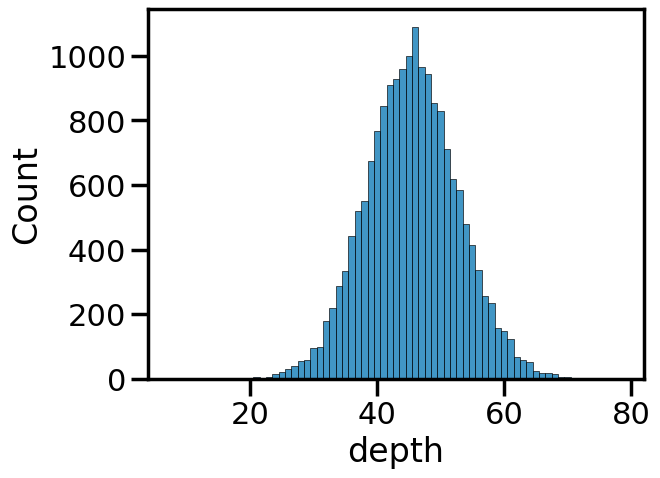

In [46]:
sns.histplot(
    df_comparison,
    x="depth",
    discrete=True,
    color=sns.color_palette("colorblind")[0]
)

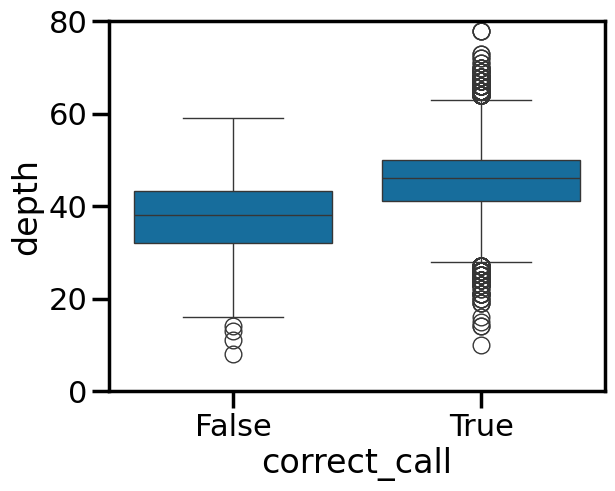

In [67]:
ax = sns.boxplot(
    df_comparison,
    x = "correct_call",
    y="depth",
    color=sns.color_palette("colorblind")[0]
)

_ = ax.set(
    ylim=(0, 80)
)

In [52]:
alpha = 0.05
lower, upper = df_comparison["depth"].quantile(alpha / 2), df_comparison["depth"].quantile(1 - (alpha / 2))
lower, upper

(32.0, 60.0)

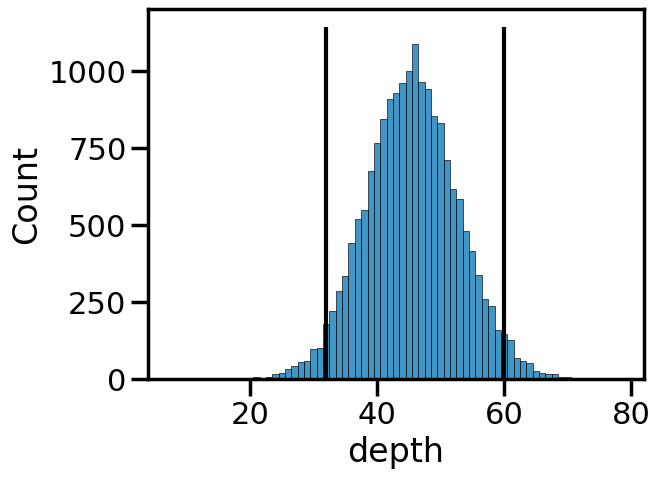

In [55]:
ax = sns.histplot(
    df_comparison,
    x="depth",
    discrete=True,
    color=sns.color_palette("colorblind")[0]
)

ax.vlines([lower, upper], 0, ax.get_ylim()[1], color="black")

In [70]:
df_comparison_filt = df_comparison.query(f"depth >= {lower} and depth <= {upper}")
print(df_comparison_filt["correct_call"].value_counts())
print(df_comparison_filt["correct_call"].value_counts(normalize=True))

correct_call
True     17133
False      100
Name: count, dtype: int64
correct_call
True     0.994197
False    0.005803
Name: proportion, dtype: float64


In [61]:
print((17948 - 17133) / 17948 * 100, "%")
print(33 / 132 * 100, "%")

4.540895921551147 %
25.0 %


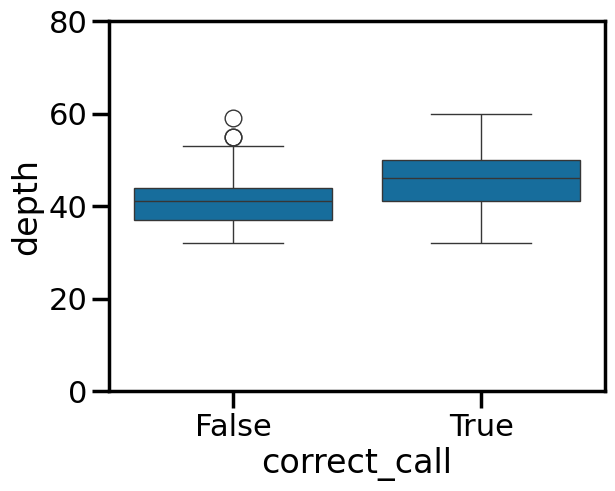

In [71]:
ax = sns.boxplot(
    df_comparison_filt,
    x = "correct_call",
    y="depth",
    color=sns.color_palette("colorblind")[0]
)

_ = ax.set(
    ylim=(0, 80)
)

In [83]:
(df_comparison_filt
 .filter(["n_distinct_alleles", "correct_call"])
 .groupby("n_distinct_alleles", as_index=False)
 .value_counts())

,n_distinct_alleles,correct_call,count
0,1,True,12919
1,2,True,3509
2,2,False,77
3,3,True,705
4,3,False,23


In [84]:
(df_comparison_filt
 .filter(["n_distinct_alleles", "correct_call"])
 .groupby("n_distinct_alleles", as_index=False)
 .value_counts(normalize=True))

,n_distinct_alleles,correct_call,proportion
0,1,True,1.000000
1,2,True,0.978528
2,2,False,0.021472
3,3,True,0.968407
4,3,False,0.031593


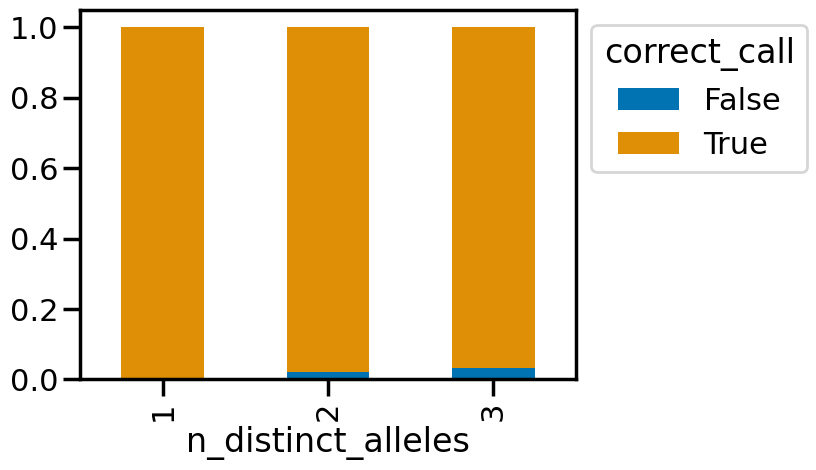

In [73]:
ax = (df_comparison_filt
 .filter(["n_distinct_alleles", "correct_call"])
 .groupby("n_distinct_alleles", as_index=True)
 .value_counts(normalize=True)
 .unstack()
 .plot(
     kind="bar", 
     stacked=True, 
     color=sns.color_palette("colorblind")[:2]))

_ = ax.get_legend().set(bbox_to_anchor = (1, 1))

In [85]:
df_comparison_filt[~df_comparison_filt["correct_call"]].head(50)

,str_id,period,ref,depth,genotype_constrain,frequencies_constrain,genotype_sim,correct_call,n_distinct_alleles
40,chr21_14146773,1,26,39,"[20, 21, 21]","{20: 14, 21: 20, 26: 5}","[20, 21, 26]",False,3
171,chr21_14438576,1,18,37,"[22, 22, 22]","{18: 6, 22: 31}","[18, 22, 22]",False,2
396,chr21_14885045,1,38,37,"[14, 38, 38]","{14: 17, 38: 20}","[14, 14, 38]",False,2
505,chr21_15109897,1,25,43,"[24, 24, 25]","{24: 22, 25: 21}","[24, 25, 25]",False,2
704,chr21_15520130,1,15,40,"[15, 16, 16]","{15: 19, 16: 21}","[15, 15, 16]",False,2
1196,chr21_16427648,1,19,38,"[19, 19, 19]","{19: 35, 20: 3}","[19, 19, 20]",False,2
1315,chr21_16630021,1,10,45,"[9, 10, 10]","{9: 21, 10: 24}","[9, 9, 10]",False,2
1330,chr21_16655781,1,10,45,"[10, 11, 11]","{10: 22, 11: 23}","[10, 10, 11]",False,2
1576,chr21_17232532,1,23,34,"[23, 23, 31]","{23: 19, 31: 8, 37: 7}","[23, 31, 37]",False,3
1644,chr21_17372825,3,8,39,"[6, 6, 8]","{6: 19, 7: 5, 8: 15}","[6, 7, 8]",False,3
